In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [3]:
ds = xr.open_dataset("with_otec/prog.nc").mean(['xh', 'yh'])
ini = xr.open_dataset("with_otec/MOM_IC.nc")

In [4]:
ds

<xarray.Dataset>
Dimensions:  (xq: 4, zl: 240, Time: 30, yq: 4, zi: 241)
Coordinates:
  * xq       (xq) float64 0.0 0.3333 0.6667 1.0
  * zl       (zl) float64 12.5 37.5 62.5 87.5 ... 5.938e+03 5.962e+03 5.988e+03
  * Time     (Time) object 0001-01-02 00:00:00 ... 0001-01-31 00:00:00
  * yq       (yq) float64 30.0 30.33 30.67 31.0
  * zi       (zi) float64 0.0 25.0 50.0 75.0 ... 5.95e+03 5.975e+03 6e+03
Data variables:
    u        (Time, zl, xq) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    v        (Time, zl, yq) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    h        (Time, zl) float64 25.0 25.0 25.0 25.0 25.0 ... 25.0 25.0 25.0 25.0
    e        (Time, zi) float32 -2.558e-13 -25.0 -50.0 ... -5.975e+03 -6e+03
    temp     (Time, zl) float32 27.79 27.76 27.65 26.72 ... 1.173 1.173 1.173
    salt     (Time, zl) float32 34.47 34.53 34.64 34.88 ... 34.69 34.69 34.69
    ea       (Time, zl) float32 0.0 4.812e-06 4.8e-06 ... 4.8e-06 4.8e-06
    eb       (Time, zl) float32 4.812e-06 4.8e-06 4.8e-06 ... 4.8e-06 0.0

/home/fdf/anaconda3/envs/otec/lib/python3.9/site-packages/nc_time_axis/__init__.py:359: CFWarning: this date/calendar/year zero convention is not supported by CF
  lower = cftime.num2date(vmin, self.date_unit, calendar=self.calendar)
/home/fdf/anaconda3/envs/otec/lib/python3.9/site-packages/nc_time_axis/__init__.py:405: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(dt, self.date_unit, calendar=self.calendar)
/home/fdf/anaconda3/envs/otec/lib/python3.9/site-packages/nc_time_axis/__init__.py:454: CFWarning: this date/calendar/year zero convention is not supported by CF
  return cftime.date2num(ticks, self.date_unit, calendar=self.calendar)
/home/fdf/anaconda3/envs/otec/lib/python3.9/site-packages/nc_time_axis/__init__.py:228: CFWarning: this date/calendar/year zero convention is not supported by CF
  dt = cftime.num2date(x, self.time_units, calendar=self.calendar)


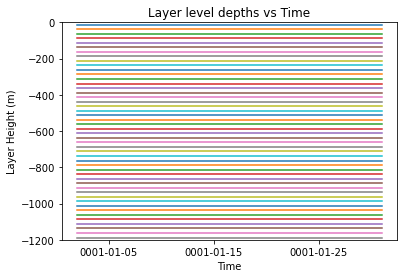

In [5]:
# Graph the depth of each layer over time
ds['eh'] = xr.ones_like(ds['h']) * 0.5*( ds['e'].sel(zi=ds['zi'][1:]).data + ds['e'].sel(zi=ds['zi'][:-1]).data )
eh = ds['eh']
for z in ds['zl']:
    eh.sel(zl=z).plot()
    
plt.ylim(-1200, 0)
plt.title("Layer level depths vs Time")
plt.ylabel("Layer Height (m)");

### Evolution of temperature profile

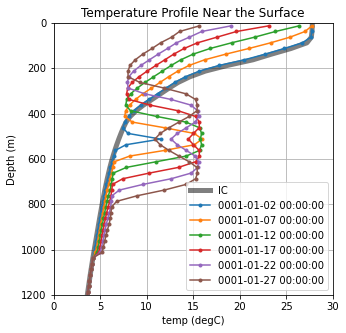

In [6]:
plt.figure(figsize=(5,5))

ini['Temp'].mean(['lath', 'lonh']).plot(y='Layer', color='k', lw=5., alpha=0.5, label="IC")
for t in ds['Time'][::5]:
    plt.plot(ds['temp'].sel(Time=t), -ds['eh'].sel(Time=t), marker=".", label=t.to_masked_array())
plt.grid(True)

plt.ylim(1200, 0)
plt.xlim(0, 30)
plt.title("Temperature Profile Near the Surface")
plt.ylabel("Depth (m)")
plt.xlabel("temp (degC)")
plt.legend();

### Show that mass sinks just shift profile towards mass source at rate of $W_{OTEC}$

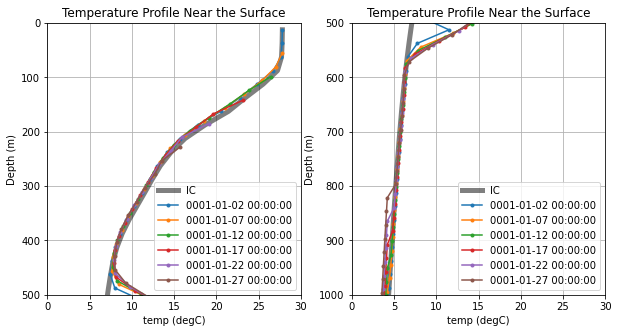

In [7]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
ini['Temp'].mean(['lath', 'lonh']).plot(y='Layer', color='k', lw=5., alpha=0.5, label="IC")
for t in ds['Time'][::5]:
    W = 0.0001
    dH = W * (t - ds['Time'][0]).astype('float64')*1e-9
    plt.plot(ds['temp'].sel(Time=t), -ds['eh'].sel(Time=t) + dH, marker=".", label=t.to_masked_array())
plt.grid(True)

plt.ylim(500, 0)
plt.xlim(0, 30)
plt.title("Temperature Profile Near the Surface")
plt.ylabel("Depth (m)")
plt.xlabel("temp (degC)")
plt.legend()

plt.subplot(1,2,2)
ini['Temp'].mean(['lath', 'lonh']).plot(y='Layer', color='k', lw=5., alpha=0.5, label="IC")
for t in ds['Time'][::5]:
    W = 0.0001
    dH = W * (t - ds['Time'][0]).astype('float64')*1e-9
    plt.plot(ds['temp'].sel(Time=t), -ds['eh'].sel(Time=t) - dH, marker=".", label=t.to_masked_array())
plt.grid(True)

plt.ylim(1000, 500)
plt.xlim(0, 30)
plt.title("Temperature Profile Near the Surface")
plt.ylabel("Depth (m)")
plt.xlabel("temp (degC)")
plt.legend();

### Evolution of salinity profile

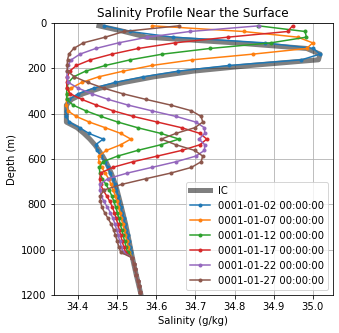

In [8]:
plt.figure(figsize=(5,5))

ini['Salt'].mean(['lath', 'lonh']).plot(y='Layer', color='k', lw=5., alpha=0.5, label="IC")
for t in ds['Time'][::5]:
    plt.plot(ds['salt'].sel(Time=t), -ds['eh'].sel(Time=t), marker=".", label=t.to_masked_array())
plt.grid(True)

plt.ylim(1200, 0)
#plt.xlim(34.3, 35.0)
plt.title("Salinity Profile Near the Surface")
plt.ylabel("Depth (m)")
plt.xlabel("Salinity (g/kg)")
plt.legend();

# Needed Pressure for Each Pump

$$ p_{prepump} = p_a + \frac{8\rho Q_{in}^2}{\pi^2 D_{in}^4} (fz_{in} / D_{in} - K_{in}) - 2\rho gz_{out} $$
$$ p_{postpump} = p_a + + 8\rho (Q_{cw} (\gamma+1))^2 / \pi^2 D_{out}^4 * (K_{out} - fz_{out} / D_{out}) - 2\rho gz_{out} $$
$$ \dot W_{pump} = Q(p_{post} - p_{pre}) $$

## Cold and Warm Pumps Separately
$$ \dot W_c = Q_{cw} (2\rho gz_{out} + \frac{8\rho Q_{cw}^2}{\pi^2} (\frac{(\gamma+1)^2}{D_{out}^4} (K_{out} - fz_{out} / D_{out}) - \frac{1}{D_c^4} (K_c - fz_c/D_c) ) - 2\rho gz_{out}) $$
$$ \dot W_w = Q_{cw} \gamma (2\rho gz_{out} + \frac{8\rho Q_{cw}^2}{\pi^2} (\frac{(\gamma+1)^2}{D_{out}^4} (K_{out} - fz_{out} / D_{out}) - \frac{1}{D_c^4} (K_w - fz_w/D_w) ) - 2\rho gz_{out}) $$
$$ \dot W = \dot W_c + \dot W_w $$

-2745915.7569342293
-2433713.607111745
-1317312.216274953


/home/fdf/anaconda3/envs/otec/lib/python3.9/site-packages/nc_time_axis/__init__.py:359: CFWarning: this date/calendar/year zero convention is not supported by CF
  lower = cftime.num2date(vmin, self.date_unit, calendar=self.calendar)
/home/fdf/anaconda3/envs/otec/lib/python3.9/site-packages/nc_time_axis/__init__.py:405: CFWarning: this date/calendar/year zero convention is not supported by CF
  cftime.num2date(dt, self.date_unit, calendar=self.calendar)
/home/fdf/anaconda3/envs/otec/lib/python3.9/site-packages/nc_time_axis/__init__.py:454: CFWarning: this date/calendar/year zero convention is not supported by CF
  return cftime.date2num(ticks, self.date_unit, calendar=self.calendar)
/home/fdf/anaconda3/envs/otec/lib/python3.9/site-packages/nc_time_axis/__init__.py:228: CFWarning: this date/calendar/year zero convention is not supported by CF
  dt = cftime.num2date(x, self.time_units, calendar=self.calendar)


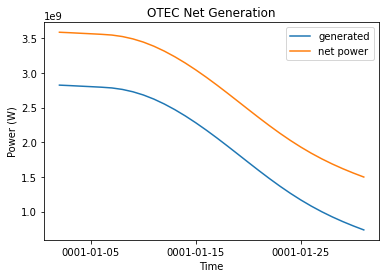

In [18]:
# initialize variables as shown above
area = 1 # of the whole ocean, in m^2

rho = 1040.
cp = 3925.
g = 9.81

z_out = -500.
z_cold = -1000.
z_warm = -20.

K = 5. # minor loss coefficient
f = .022 # pipe friction coefficient
D = 5. # pipe diameter

# temperature at the surface
T_top = ds['temp'].sel(zl=20, method='nearest')
dT = T_top - ds['temp'].sel(zl=1000, method='nearest')

# design conditions = initial conditions at 1000m and mixed layer
# T_design = ini['Temp'][0,0]
# dT_design = T_design - ini['Temp'].sel(Layer=1000, method='nearest')[0]
# NOTE: These gave data that made no sense. Instead I now assume T_design=T and dT_design = dT
T_design = T_top
dT_design = dT

# Input w_cw in m/year.
def plotpower(w_cw, gamma, eff_tg, eff_pump):
    Q_cw = w_cw * area
    
    # coefficient to multiply by both powers involved
    coeff = Q_cw*rho*cp*eff_tg / (8*T_top)
    # generator
    W_gen = 3*coeff * (dT**2) / (2*(1+gamma))

    # pressure after and before the two pumps
    p_post = 8*rho/(np.pi**2 * D**4) * (Q_cw*(gamma+1))**2 * (K - f*z_out/D) - 2*rho*g*z_out
    print(p_post)
    p_cold = 8*rho*(Q_cw**2)/(np.pi**2 * D**4) * (f*z_cold/D - K)
    print(p_cold)
    p_warm = 8*rho*(Q_cw*gamma)**2 / (np.pi**2 * D**4) * (f*z_warm/D - K)
    print(p_warm)

    W_para = (Q_cw*(p_post - p_cold) + Q_cw*gamma*(p_post - p_warm))/eff_pump # parasitic power

    W_net = W_gen - W_para
    
    W_gen.plot(label='generated')
    #W_para.plot(label='parasitic')
    W_net.plot(label='net power')
    plt.title('OTEC Net Generation')
    plt.ylabel('Power (W)')
    plt.legend()

plotpower(438.126, 1., 0.85, 0.9)